# Discrete LQR

**Goal:** select control inputs to minimize
\begin{eqnarray}
J&=&\frac{1}{2}\mathbf{x}_N^TR_{xx_N} \mathbf{x}_N +
\frac{1}{2}\sum_{k=0}^{N-1}[\mathbf{x}_k^TR_{xx_k}\mathbf{x}_k+\mathbf{u}^T_kR_{uu_k}\mathbf{u}_k] \\
\text{Dynamics:} \quad 
\mathbf{x}_{k+1}&=&A_k\mathbf{ x}_k + B_k \mathbf{ u}_k
\end{eqnarray}

* Assume that $R_{xx_N}=R_{xx_N}^T \geq 0$, $R_{xx}=R_{xx}^T \geq 0$, and $R_{uu}=R_{uu}^T > 0 $

As on 16-17, for LQR we itialize with $P_N=R_{xx_N}$ and then solve backwards from $N-1$ to $0$ using the following iteration:
\begin{eqnarray}
(i) F_k&=&\left[R_{uu_k}+B_{k}^TP_{k+1}B_{k}\right]^{-1} B_{k}^T
P_{k+1} A_{k} \\ (ii)
P_k &=& R_{xx_k} +
	A_{k}^T\left\{ P_{k+1} - P_{k+1} B_{k}
	\left[R_{k}+B_{k}^TP_{k+1}B_{k}\right]^{-1} B_k^T P_{k+1} \right\}
	A_{k}
\end{eqnarray}
This yields a time-varying control since $F$ changes with $k$. 

* Typically we implement a time-invariant controller $u[k]=-Fx[k]$, where $F$ is found using the equation above with $P_{k+1}$ replaced with the solution of 
$$ 
P_{ss} = R_{xx} + A^T\left\{ P_{ss} - P_{ss} B
\left[R_{uu}+B^TP_{ss}B\right]^{-1} B^T P_{ss} \right\} A  
$$

* If the system $[A,B,C]$ (where $R_{xx}=C^TC$) is stabilizable and observable, then the iteration for $P_k$ converges to the unique solution for $P_{ss} > 0$

* This notebook explores the role of $H$ in the $P_k$ and the differences in state response in using $F$ and $F_k$ in the feeback control.

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

import random, sys
import scipy.linalg
from scipy import linalg as la

from sympy import Matrix, init_printing
init_printing()

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 
from IPython.display import display

from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.8.16


## Scalar Example

In [2]:
n = 1                                # state dim
N = 10                               # LQR time steps
A = np.array([1.0]) # dynamics matrix
B = np.array([1.0])             # input matrix
RxxN = np.array([1/4])     # terminal state cost 
P = np.zeros((n,n,N+1))              # cost to go matrix
Rxx = np.array([1])     # state cost in LQR
Ruu = np.array([2])                   # control cost in LQR
K = np.arange(N+1)                   # time horizon   

# backward recursion for P and F
F = np.zeros((1,n,N))              # gains
P = np.zeros((n,n,N+1))
P[:,:,N] = RxxN                        # P initialization
for k in np.arange(N-1,-1,-1):
    P[:,:,k] = Rxx+A.T@(P[:,:,k+1]-np.atleast_2d(P[:,:,k+1]@B@np.linalg.inv(np.atleast_2d(Ruu+B.T@P[:,:,k+1]@B))@B.T)@P[:,:,k+1])@A
    F[:,:,k] = np.linalg.inv(np.atleast_2d(Ruu+B.T@P[:,:,k+1]@B))@B.T@P[:,:,k+1]@A  

In [3]:
# Steady State Solution
Pss = la.solve_discrete_are(A, B, Rxx, Ruu) # There are 2 ARE of interest, make sure you are using the right one
print('P steady state value')
display(Matrix(np.round(Pss,4)))
print('\nCompare to P Numerical')
display(Matrix(np.round(P[:,:,0],4)))

Fss = B.T@Pss@A/(Ruu+B.T@Pss@B)
print('\nComputed Steady State Gain')
display(Matrix(np.round(Fss,4)))
print('\nCompare to Numerical Gain')
display(Matrix(np.round(F[:,:,0],4)))

P steady state value



Compare to P Numerical



Computed Steady State Gain



Compare to Numerical Gain


## Sub Optimal Cost to Go $S$

In [4]:
F_sub_opt = np.array([0.25])
Acl_sub_opt = A - B@F_sub_opt
S = np.zeros((n,n,N+1))
S[:,:,N] = RxxN                         # P initialization

for k in np.arange(N-1,-1,-1):
    S[:,:,k] = Rxx + np.atleast_2d(F_sub_opt.T@Ruu)@F_sub_opt + np.atleast_2d(Acl_sub_opt.T@S[:,:,k+1])@Acl_sub_opt

Acl_ss = A - B@Fss
S_ss = np.zeros((n,n,N+1))
S_ss[:,:,N] = RxxN                         # P initialization
for k in np.arange(N-1,-1,-1):
    S_ss[:,:,k] = Rxx + np.atleast_2d(Fss.T@Ruu)@Fss + np.atleast_2d(Acl_ss.T@S_ss[:,:,k+1])@Acl_ss


## Optimal Cost to Go $P$

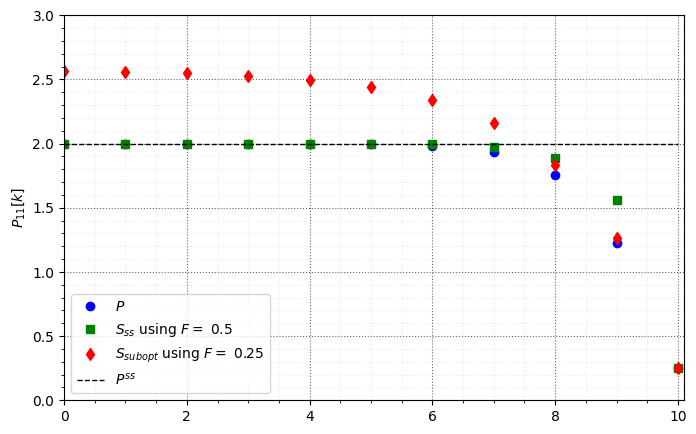

In [5]:
plt.figure(1,figsize=(8,5))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(K,P[0,0,:],'bo',ms=6,label=r'$P$')
ax1.plot(K,S_ss[0,0,:],'gs',ms=6,label=r'$S_{ss}$ using $F=$ '+str(np.round(Fss.item(),3))  )
ax1.plot(K,S[0,0,:],'rd',ms=6,label=r'$S_{subopt}$ using $F=$ '+str(F_sub_opt.item()))
ax1.plot([0,N],[Pss[0,0],Pss[0,0]],'k--',lw=1,label=r'$P^{ss}$')
plt.ylim([0,3])
plt.xlim([0,N+0.1])
plt.ylabel(r'$P_{11}[k]$')
nicegrid()
plt.legend(loc='best')
plt.tight_layout
plt.savefig("figs/DLQR_ex1_1.png")
plt.show()

The plots show that, if $N$ is large then $P_k$ can easily converge to $P_{ss}$ 

## Control Gains $F$

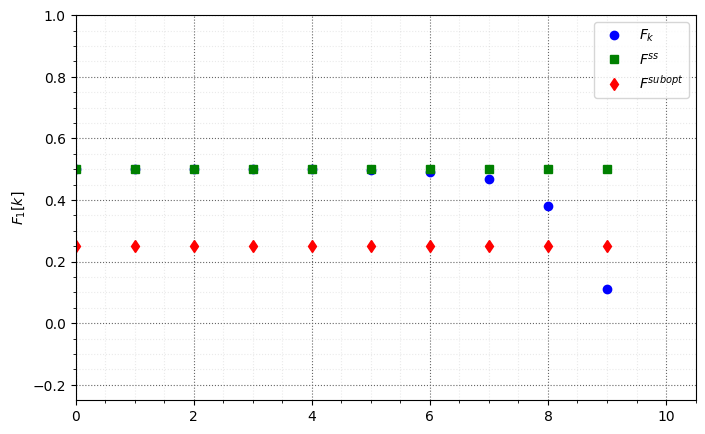

In [6]:
plt.figure(2,figsize=(8,5))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(K[:-1],F[0,0,:],'bo',ms=6,label=r'$F_k$')
ax1.plot(K[:-1],np.ones_like(K[:-1])*Fss[0],'gs',label=r'$F^{ss}$')
ax1.plot(K[:-1],np.ones_like(K[:-1])*F_sub_opt[0],'rd',label=r'$F^{subopt}$')
plt.ylim([-0.01,round(1.5*Fss[0],1)])
plt.xlim([0,N+0.5])
plt.ylim([-0.25,1])
plt.ylabel(r'$F_1[k]$')
plt.legend(loc='best')
nicegrid()
plt.savefig("figs/DLQR_ex1_2.png")
plt.show()

The time-varying gains $F_k$ and steady state gains $F$ are similar for small $k$, which will be the stat of the state simulation. Thus would expect the state response to be similar for both. The gains for larger $k$ will depend heavily on $R_{xx_N}$ -- is the terminal state penalized more/less heavily? 

In [7]:
# state response
x0 = np.array([1])    # state initial condition
X = np.zeros((n,1,N+1))
Xss = np.zeros((n,1,N+1))
X_sub_opt = np.zeros((n,1,N+1))
X[:,0,0] = x0
Xss[:,0,0] = x0
X_sub_opt[:,0,0] = x0


for k in np.arange(1,N+1):
        Acl = A - B@F[:,:,k-1]
        X[:,0,k] = Acl@X[:,0,k-1]
        Xss[:,0,k] = Acl_ss@Xss[:,0,k-1]        
        X_sub_opt[:,0,k] = Acl_sub_opt@X_sub_opt[:,0,k-1]

## State response
Compare state response using optimal and suboptimal (steady state $F$) gains.

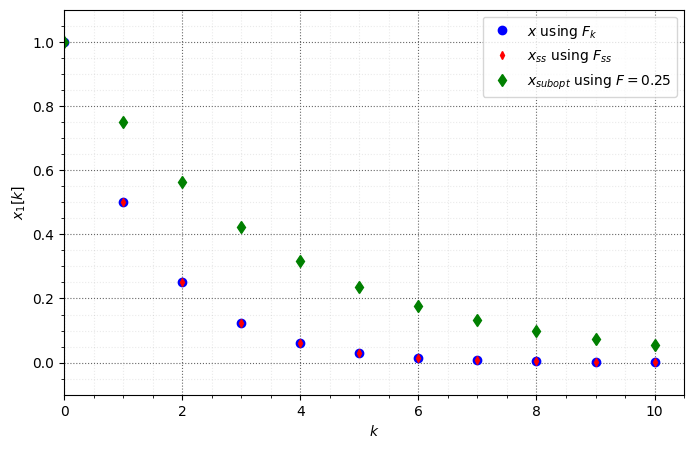

In [8]:
plt.figure(3,figsize=(8,5))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(K,X[0,0,:],'bo',ms=6,label=r'$x$ using $F_k$')
ax1.plot(K,Xss[0,0,:],'rd',ms=4,label=r'$x_{ss}$ using $F_{ss}$')
ax1.plot(K,X_sub_opt[0,0,:],'gd',ms=6,label=r'$x_{sub opt}$ using $F=0.25$')
plt.ylim([0-0.1,1.1])
plt.xlim([0,N+0.5])
plt.ylabel(r'$x_1[k]$')
nicegrid()
plt.legend(loc='best')
plt.xlabel(r'$k$')
plt.savefig("figs/DLQR_ex1_3.png")
plt.show()

See large differences in the cost to go matrices $P[k]$ and $P_{ss}$, but the state response of $u[k]=-F_{ss}x[k]$ is still very similar to that from $u[k]=-F_{k}x[k]$ 
* Typically see that the state has already convereged close to 0 before the differences in the control gains are evident

## Comparison of effect of $N$ and $R_{xx_N}$

In [ ]:
# Try perturbing the final cost to see impact on the state response

def f(logbeta = 0, N = 10):
    Fp = np.zeros((1,n,N))
    Pp = np.zeros((n,n,N+1))
    Fp1 = np.zeros((1,n,N))
    Pp1 = np.zeros((n,n,N+1))
    Pp[:,:,N] = RxxN
    Pp1[:,:,N] = (10**logbeta)*RxxN
    for k in np.arange(N-1,-1,-1):
        Pp[:,:,k] = Rxx+A.T@(Pp[:,:,k+1]-np.atleast_2d(Pp[:,:,k+1]@B@np.linalg.inv(np.atleast_2d(Ruu+B.T@Pp[:,:,k+1]@B))@B.T)@Pp[:,:,k+1])@A
        Fp[:,:,k] = np.atleast_2d(B.T@Pp[:,:,k+1]@A)@np.linalg.inv(np.atleast_2d(Ruu+B.T@Pp[:,:,k+1]@B))   
        Pp1[:,:,k] = Rxx+A.T@(Pp1[:,:,k+1]-np.atleast_2d(Pp1[:,:,k+1]@B@np.linalg.inv(np.atleast_2d(Ruu+B.T@Pp1[:,:,k+1]@B))@B.T)@Pp1[:,:,k+1])@A
        Fp1[:,:,k] = np.atleast_2d(B.T@Pp1[:,:,k+1]@A)@np.linalg.inv(np.atleast_2d(Ruu+B.T@Pp1[:,:,k+1]@B))   

    Xp = np.zeros((n,1,N+1))
    Xp[:,0,0] = x0
    Xp1 = np.zeros((n,1,N+1))
    Xp1[:,0,0] = x0
    Xss = np.zeros((n,1,N+1))
    Xss[:,0,0] = x0
    Acl = (A - B@Fss)
    for k in np.arange(1,N+1):
        Xp[:,0,k] = (A - B@Fp[:,:,k-1])@Xp[:,0,k-1]
        Xp1[:,0,k] = (A - B@Fp1[:,:,k-1])@Xp1[:,0,k-1]
        Xss[:,0,k] = Acl@Xss[:,0,k-1]

    KN=np.arange(N+1)
    plt.figure(4,figsize=(12,8))
    ax1 = plt.subplot(211)
    ax1.plot(KN[:-1],Fp[0,0,:],'bo',ms=4,label=r'$F_{1}$ using $R_{xx_N}$')
    ax1.plot(KN[:-1],Fp1[0,0,:],'rd',ms=2,label=r'$F_{1}$ using '+str(round(10**logbeta,1))+'$R_{xx_N}$')
    ax1.plot([0,N-1],[Fss[0],Fss[0]],'k--',label=r'$F^{ss}_{1}$')
    plt.xlim([0,N+0.1])
    ax1.legend(loc=3)
    plt.ylabel(r'$F_{1}[k]$')
    nicegrid()
    ax4 = plt.subplot(212)
    ax4.plot(KN,Xp[0,0,:],'bo',ms=6,label=r'$x$ using $F_k$ with $R_{xx_N}$')
    ax4.plot(KN,Xp1[0,0,:],'gs',ms=4,label=r'$x$ using $F_k$ with '+str(round(10**logbeta,1))+'$R_{xx_N}$')
    ax4.plot(KN,Xss[0,0,:],'rd',ms=2,label=r'$x$ using $F_{ss}$')
    plt.ylim([-1,round(1.5*np.max(Xp[0,0,:]),1)])
    plt.ylabel(r'$x_1[k]$')
    plt.legend(loc='best')
    plt.xlim([0,N+0.1])
    nicegrid()
    plt.xlabel(r'$k$')
    plt.tight_layout
    plt.show()

interactive_plot = interactive(f, {'manual': False}, logbeta=(-1,6,0.5), N=(4,40,2))
output = interactive_plot.children[-1]
interactive_plot


As $\beta$ is increased, would expect to see larger differences in the state response for $k$ near $N$